In [1]:
import os
import json
from typing import List, Literal, Optional, Text, Union, Dict, Any
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
from agents.agents_modules.workflow import build_agent_workflow
from agents.dataloader import load_dataset_by_name, extract_example
from agents.utilities.agent_utils import save_result_to_json
from agents.llm_model import UnifiedModel, model_name
from agents.agent_prompts import END_TO_END_GENERATION_PROMPT, input_prompt #,CONTENT_SELECTION_PROMPT

/home/chinonso/anaconda3/envs/lang2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


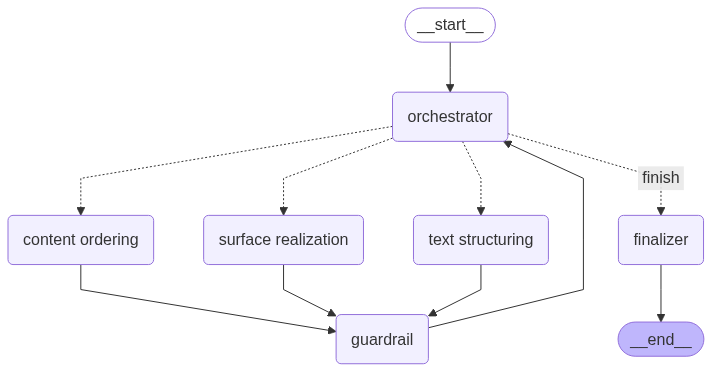

In [2]:
provider = "openai" #ollama, openai, hf, aixplain
process_flow = build_agent_workflow(provider=provider)
display(Image(process_flow.get_graph(xray=True).draw_mermaid_png()))

In [3]:
# from agents.dataloader import load_dataset_by_name, extract_example
# Exclude turku_hockey and conversational_weather
# totto, webnlg, dart, rotowire, sportsett_basketball, mlb
name = "webnlg_hf"
num = 549 # Sample id 1037
set = "test"

data = load_dataset_by_name(name)
dataset = data[set]
sample = extract_example(name, data[set][num])
data = sample.get('input', '')
ground_truth = sample.get('references', "")
target = sample.get('target', "")

print(f"Size: {len(dataset)}")
print("========== INPUT DATA ==========")
print(f"{data}\n")
print("========== TARGET (if any) ==========")
print(f"{target}\n")
print("========== GROUND TRUTH REFERENCES ==========")
print(f"{ground_truth}")


Loading dataset: webnlg_hf
Size: 1779
========== INPUT DATA ==========
["It's_Great_to_Be_Young_(1956_film) | editing | Max_Benedict", 'Max_Benedict | activeYearsStartYear | 1947-01-01', "It's_Great_to_Be_Young_(1956_film) | runtime | 94.0", "It's_Great_to_Be_Young_(1956_film) | director | Cyril_Frankel"]

========== TARGET (if any) ==========
It's Great to Be Young (1956, 94 minutes) is a film edited by Max Benedict, who has been active in the film industry since 1947. The director of the movie is Cyril Frankel.

========== GROUND TRUTH REFERENCES ==========
["It's Great to Be Young (1956, 94 minutes) is a film edited by Max Benedict, who has been active in the film industry since 1947. The director of the movie is Cyril Frankel.", "Max Benedict, who began his career in 1947 edited It's Great to be Young, a 1956 94 minute film directed by Cyril Frankel.", "It's Great to Be Young, a 1956 film directed by Cyril Frankel, runs for 94 minutes. Max Benedict, who started working in 1947, edi

In [4]:
query = f"""You are an agent designed to generate text from data for a data-to-text natural language generation. You can be provided data in the form of xml, table, meaning representations, graphs etc. 
Your task is to generate the appropriate text given the data information without omitting any field or adding extra information in essence called hallucination.

Dataset: {'webnlg' if name == 'webnlg_hf' else name}
Here is the data, generate text using the provided data:
{data}"""

initial_state = {
    "user_prompt": query,
    "raw_data": data,
    "history_of_steps": [],
    "final_response": "",
    "next_agent": "",
    "next_agent_payload": "",
    "current_step": 0,
    "iteration_count": 0,
    "max_iteration": 100,
}

state = process_flow.invoke(initial_state, config={"recursion_limit": initial_state["max_iteration"]})
prediction = state['final_response']



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Final Answer",
  "action_input": ["It's_Great_to_Be_Young_(1956_film) | director | Cyril_Frankel", "It's_Great_to_Be_Young_(1956_film) | runtime | 94.0", "It's_Great_to_Be_Young_(1956_film) | editing | Max_Benedict", "Max_Benedict | activeYearsStartYear | 1947-01-01"]
}
```

> Finished chain.


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Final Answer",
  "action_input": "<paragraph>\n  <snt>\n    It's_Great_to_Be_Young_(1956_film) | director | Cyril_Frankel\n    It's_Great_to_Be_Young_(1956_film) | runtime | 94.0\n  </snt>\n  <snt>\n    It's_Great_to_Be_Young_(1956_film) | editing | Max_Benedict\n    Max_Benedict | activeYearsStartYear | 1947-01-01\n  </snt>\n</paragraph>"
}
```

> Finished chain.


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Final Answer",
  "action_input": "The 1956 film \"It's Great to Be Young\" was directed by Cyril Frankel and has a runtime of 94 minutes. 

In [5]:
# save_result_to_json(state, dataset_folder=f"{name}", filename=f"{name}_{num}.json")
# save_result_to_json(state, filename=f"webnlg_long.json")

In [6]:
print(prediction)

The 1956 film "It's Great to Be Young" was directed by Cyril Frankel and has a runtime of 94 minutes. The film was edited by Max Benedict, who began his career in 1947.


In [7]:
ground_truth

["It's Great to Be Young (1956, 94 minutes) is a film edited by Max Benedict, who has been active in the film industry since 1947. The director of the movie is Cyril Frankel.",
 "Max Benedict, who began his career in 1947 edited It's Great to be Young, a 1956 94 minute film directed by Cyril Frankel.",
 "It's Great to Be Young, a 1956 film directed by Cyril Frankel, runs for 94 minutes. Max Benedict, who started working in 1947, edited the film."]

In [8]:
target

"It's Great to Be Young (1956, 94 minutes) is a film edited by Max Benedict, who has been active in the film industry since 1947. The director of the movie is Cyril Frankel."

In [9]:
from agents.evaluator import evaluate_single

scores = evaluate_single(target, prediction, data)
for metric, score in scores.items():
    print(f"{metric}: {score:.4f}")

2025-07-03 19:30:44.204377: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 19:30:44.211320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751567444.219542   53614 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751567444.222275   53614 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751567444.229153   53614 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

BLEU: 0.3119
METEOR: 0.6363
ROUGE-F1: 0.5232
COMET: 0.8347
BLEURT: 0.6810
BERTScore-F1: 0.9313


In [10]:
# import json

# def build_d2t_prompt(name, num_examples, input_data, samples_file="random_train_samples.json"):
#     """
#     Build a few-shot prompt for data-to-text generation.

#     Args:
#         name (str): Dataset name to filter (e.g., "totto").
#         num_examples (int): Number of examples to include.
#         input_data (str): The data string for the query Data: ... block.
#         samples_file (str): Path to random samples JSON.

#     Returns:
#         str: Prompt string ready for use.
#     """
#     with open(samples_file, "r", encoding="utf-8") as f:
#         results = json.load(f)

#     filtered = [
#         ex for ex in results
#         if ex.get("dataset") == name and ex.get("input", "").strip()
#         and (ex.get("target", "").strip() or (ex.get("references") and any(r.strip() for r in ex["references"])))
#     ]

#     examples = filtered[:num_examples]
#     if len(examples) < num_examples:
#         print(f"Only {len(examples)} examples found for dataset '{name}'")

#     prompt_blocks = []
#     for i, ex in enumerate(examples, 1):
#         input_text = ex.get("input", "").strip()
#         output = ex.get("target", "").strip()
#         if not output:
#             refs = [r.strip() for r in ex.get("references", []) if r.strip()]
#             output = refs[0] if refs else ""
#         prompt_blocks.append(f"Example {i}:\nData: {input_text}\nOutput: {output}\n")

#     prompt_examples = "\n".join(prompt_blocks)

#     prompt_template = f"""You are an agent designed to generate text from data for a data-to-text natural language generation. 
# You can be provided data in the form of xml, table, meaning representations, graphs etc.
# Your task is to generate the appropriate text given the data information without omitting any field or adding extra information in essence called hallucination.

# Dataset: {'webnlg' if name == 'webnlg_hf' else name}

# Examples:
# {prompt_examples}

# Here is the data, now generate text using the provided data:

# Data: {input_data}
# Output: """
#     return prompt_template

# # Example usage:
# prompt = build_d2t_prompt("totto", 5, data)
# print(prompt)


In [11]:
# conf = model_name.get(provider.lower(), {}).copy()
# conf["temperature"] = 0.0
# llm = UnifiedModel(provider=provider, **conf).model_(CONTENT_SELECTION_PROMPT)
# CS_prediction = llm.invoke({'input': data}).content.strip()
# print(CS_prediction)

In [12]:
# data = """[['Lagos', 'areaLand', '999600000.0'],
#  ['Lagos', 'areaMetro', '2706700000.0'],
#  ['Lagos', 'areaUrban', '907000000.0'],
#  ['Lagos', 'populationMetro', '21320000'],
#  ['Lagos', 'populationMetroDensity', '7759.0'],
#  ['Lagos', 'areaMetro', '2706.7'],
#  ['Lagos', 'areaTotal', '1171.28'],
#  ['Lagos', 'areaUrban', '907.0'],
#  ['Lagos', 'populationDensity', '6871.0'],
#  ['Lagos', 'populationMetroDensity', '7759.0'],
#  ['Lagos', 'areaCode', '010'],
#  ['Lagos', 'areaTotal', '1171280000.0'],
#  ['Lagos', 'demonym', 'Lagosian'],
#  ['Lagos', 'motto', 'Èkó ò ní bàjé o!'],
#  ['Lagos', 'populationDensity', '6871.0'],
#  ['Lagos', 'populationTotal', '8048430'],
#  ['Lagos', 'utcOffset', '+1'],
#  ['Lagos', 'country', 'Nigeria'],
#  ['Lagos', 'founder', 'Awori_tribe'],
#  ['Lagos', 'timeZone', 'West_Africa_Time'],
#  ['Benfruit_Plant', 'location', 'Lagos'],
#  ['Nigerian_Institute_of_Management', 'location', 'Lagos'],
#  ['Before_30', 'location', 'Lagos'],
#  ['Reduction_of_Lagos', 'place', 'Lagos'],
#  ["Cait_O'Riordan", 'birthPlace', 'Lagos'],
#  ['Candy_Augustine_Agbane', 'birthPlace', 'Lagos'],
#  ['Carol_King_(actress)', 'birthPlace', 'Lagos'],
#  ['Amusa_Shittu', 'deathPlace', 'Lagos'],
#  ['Samuel_Ajayi_Crowther', 'deathPlace', 'Lagos'],
#  ['Samuel_Johnson_(Nigerian_historian)', 'deathPlace', 'Lagos'],
#  ['Dobox', 'foundationPlace', 'Lagos'],
#  ['IROKO_Partners', 'foundationPlace', 'Lagos'],
#  ['Isaac_Fola-Alade', 'significantBuilding', 'Lagos'],
#  ['Olufemi_Majekodunmi', 'significantBuilding', 'Lagos'],
#  ['Cally_Air', 'targetAirport', 'Lagos'],
#  ['Ibom_Air', 'targetAirport', 'Lagos'],
#  ['Max_Air', 'targetAirport', 'Lagos'],
#  ['Isaac_Fola-Alade', 'significantProject', 'Lagos'],
#  ['ADC_Airlines', 'hubAirport', 'Lagos'],
#  ['Babington_Macaulay_Junior_Seminary', 'state', 'Lagos'],
#  ['Government_College_Ikorodu', 'state', 'Lagos'],
#  ['Ebun_Oluwa_Pro_Veritas', 'state', 'Lagos'],
#  ['Colonial_Nigeria', 'capital', 'Lagos'],
#  ['Federation_of_Nigeria', 'capital', 'Lagos'],
#  ['Lagos_Colony', 'capital', 'Lagos'],
#  ['African_Union', 'largestCity', 'Lagos'],
#  ['Nigeria', 'largestCity', 'Lagos'],
#  ['Military_dictatorship_in_Nigeria', 'largestCity', 'Lagos'],
#  ['Volkswagen_Beetle', 'assembly', 'Lagos'],
#  ['Volkswagen_Jetta_(A2)', 'assembly', 'Lagos'],
#  ['Isuzu_Forward', 'assembly', 'Lagos'],
#  ['Juliet_Ibrahim', 'award', 'Lagos'],
#  ['Benin-Ore-Shagamu_Expressway', 'city', 'Lagos'],
#  ['Encomium_Magazine', 'city', 'Lagos'],
#  ['Bogobiri_House', 'city', 'Lagos'],
#  ['Sub-Saharan_Africa', 'country', 'Lagos'],
#  ['Desmond_Majekodunmi', 'education', 'Lagos'],
#  ['Buchi_Emecheta', 'education', 'Lagos'],
#  ['Habeeb_Okunola', 'education', 'Lagos'],
#  ['MFM_F.C.', 'ground', 'Lagos'],
#  ['ACB_Lagos_F.C.', 'ground', 'Lagos'],
#  ['COD_United_F.C.', 'ground', 'Lagos'],
#  ['Caritas_Communications', 'headquarter', 'Lagos'],
#  ['Nigerian_Accounting_Association', 'headquarter', 'Lagos'],
#  ['Merchant_Express_Aviation', 'headquarter', 'Lagos'],
#  ['Sasha_P', 'hometown', 'Lagos'],
#  ['Davina_Oriakhi', 'hometown', 'Lagos'],
#  ['VanJess', 'hometown', 'Lagos'],
#  ['Olu_Amoda', 'knownFor', 'Lagos'],
#  ['Toki_Mabogunje', 'knownFor', 'Lagos'],
#  ['United_Africa_Company_of_Nigeria', 'locationCity', 'Lagos'],
#  ['Promasidor_Nigeria', 'locationCity', 'Lagos'],
#  ['G-Worldwide_Entertainment', 'locationCity', 'Lagos'],
#  ['LADOL', 'locationCountry', 'Lagos'],
#  ['Atlantic_Ocean', 'nearestCity', 'Lagos'],
#  ['Lagos_Lagoon', 'nearestCity', 'Lagos'],
#  ['Let_Me_Roll_It', 'recordedIn', 'Lagos'],
#  ['Mamunia', 'recordedIn', 'Lagos'],
#  ['Band_on_the_Run_(song)', 'recordedIn', 'Lagos'],
#  ['First_Consultant_Hospital', 'region', 'Lagos'],
#  ['National_Orthopaedic_Hospital,_Igbobi', 'region', 'Lagos'],
#  ['GIG_Mobility', 'regionServed', 'Lagos'],
#  ['TEDxLagos', 'regionServed', 'Lagos'],
#  ['Patrick_Utomi', 'residence', 'Lagos'],
#  ['Dakuku_Peterside', 'residence', 'Lagos'],
#  ['Mudashiru_Obasa', 'residence', 'Lagos']]"""

In [13]:
# lagos_86 = """Lagos is located in Nigeria, and its inhabitants are known as Lagosians. The city's motto is 'Èkó ò ní bàjé o!' and it was founded by the Awori tribe. Lagos operates on West Africa Time, with a UTC offset of +1. The land area of Lagos covers 999.6 square kilometers, with the urban area measuring 907 square kilometers, while the metropolitan area spans 2,706.7 square kilometers. The total area of the city is 1,171.28 square kilometers. Lagos has a population of 8,048,430, with a population density of 6,871 people per square kilometer, while the metropolitan population reaches 21,320,000 with a metro density of 7,759 per square kilometer. The city's area code is 010.

# The Atlantic Ocean and Lagos Lagoon are closest to Lagos. It is recognized as the largest city within the African Union, Nigeria, and during the Military dictatorship in Nigeria. Lagos has also served as the capital of Colonial Nigeria, the Federation of Nigeria, and the Lagos Colony. In Sub-Saharan Africa, Lagos is counted among its prominent cities.

# Numerous institutions and organizations are based in Lagos, such as Benfruit Plant, the Nigerian Institute of Management, and Before 30. The city is also the foundation place of Dobox and IROKO Partners. Companies like Caritas Communications, the Nigerian Accounting Association, and Merchant Express Aviation have their headquarters in Lagos. The United Africa Company of Nigeria, Promasidor Nigeria, and G-Worldwide Entertainment are all located in the city. LADOL is also situated in Lagos. Lagos serves as the region for GIG Mobility and TEDxLagos, as well as for First Consultant Hospital and National Orthopaedic Hospital, Igbobi. Notable locations like the Benin-Ore-Shagamu Expressway, Encomium Magazine, and Bogobiri House are found here, and educational institutions such as Babington Macaulay Junior Seminary, Government College Ikorodu, and Ebun Oluwa Pro Veritas are located within Lagos State. Lagos is home to the grounds of MFM F.C., ACB Lagos F.C., and COD United F.C., and is associated with the assembly of vehicles like the Volkswagen Beetle, Volkswagen Jetta (A2), and Isuzu Forward. The city is known for significant buildings designed by Isaac Fola-Alade and Olufemi Majekodunmi, as well as a significant project by Isaac Fola-Alade. Music recordings such as 'Let Me Roll It', 'Mamunia', and 'Band on the Run' were recorded in Lagos. The city is notable for the historic Reduction of Lagos, and features as a target airport for airlines including Cally Air, Ibom Air, and Max Air, while also serving as a hub for ADC Airlines.

# Lagos is the hometown of personalities such as Sasha P, Davina Oriakhi, and VanJess. It is likewise the birthplace of Cait O'Riordan, Candy Augustine Agbane, and Carol King the actress. The city is where figures like Amusa Shittu, Samuel Ajayi Crowther, and Samuel Johnson, the Nigerian historian, passed away. It is home to residents including Patrick Utomi, Dakuku Peterside, and Mudashiru Obasa. Individuals such as Olu Amoda and Toki Mabogunje are known for their connections to Lagos. The city is where Desmond Majekodunmi, Buchi Emecheta, and Habeeb Okunola received their education, and Juliet Ibrahim is among those who have received awards in Lagos."""

# print(lagos_86)

In [14]:
# import json
# from pathlib import Path

# src = "results/webnlg_e2e.json"
# src_path = Path(src)
# dst_path = Path(src.split('.')[0])

# with src_path.open(encoding="utf-8") as src, dst_path.open("w", encoding="utf-8") as dst:
#     for lineno, line in enumerate(src, 1):
#         line = line.strip()
#         if not line:          # skip blank lines
#             continue
#         try:
#             obj = json.loads(line)
#         except json.JSONDecodeError as exc:
#             print(f"⚠️  skip line {lineno}: {exc}")
#             continue

#         # Normalise whitespace: collapse any CR/LF runs to a single space
#         pred = " ".join(obj.get("prediction", "").replace("\n", " ").split())
#         if pred:
#             dst.write(pred + "\n")

# print(f"Finished – cleaned predictions saved to {dst_path}")


In [15]:
# import json
# import random
# from agents.dataloader import load_dataset_by_name, extract_example

# datasets = ["totto", "webnlg_hf", "dart", "rotowire", "sportsett_basketball", "mlb"]
# samples_per_dataset = 5

# results = []

# for name in datasets:
#     data = load_dataset_by_name(name)
#     dataset = data["train"]
#     indices = random.sample(range(len(dataset)), min(samples_per_dataset, len(dataset)))
#     for idx in indices:
#         sample = extract_example(name, dataset[idx])
#         results.append({
#             "dataset": 'webnlg' if name=='webnlg_hf' else name,
#             "input": sample.get("input", ""),
#             "target": sample.get("target", ""),
#             "references": sample.get("references", [])
#         })

# with open("random_train_samples.json", "w", encoding="utf-8") as f:
#     json.dump(results, f, indent=2, ensure_ascii=False)

# print("Saved to random_train_samples.json")


In [16]:
# import json

# def extract_phase_examples(json_path, dataset, phase, max_examples=5):
#     with open(json_path, 'r', encoding='utf-8') as f:
#         data = json.load(f)

#     # Filter only examples matching the dataset name
#     filtered = [ex for ex in data if ex.get("dataset") == dataset]

#     count = 0
#     for i, ex in enumerate(filtered[:max_examples], 1):
#         # Content Ordering
#         if phase == "content ordering" and "ordering" in ex:
#             print(f"Example {i}:\nData:\n{ex['input']}\nOutput:\n{ex['ordering']}\n")
#             count += 1
#         # Text Structuring
#         elif phase == "text structuring" and "ordering" in ex and "structuring" in ex:
#             print(f"Example {i}:\nData:\n{ex['ordering']}\nOutput:\n{ex['structuring']}\n")
#             count += 1
#         # Surface Realization
#         elif phase == "surface realization" and "structuring" in ex:
#             # Prefer 'target', else 'references'
#             output = ex.get('target', None)
#             if not output and ex.get("references"):
#                 output = ex["references"]
#             print(f"Example {i}:\nData:\n{ex['structuring']}\nOutput:\n{output}\n")
#             count += 1

#     # print(f"Total {phase} examples printed: {count}")

# # Usage example:
# extract_phase_examples('random_train_samples.json', 'webnlg', 'surface realization', max_examples=5)
